# Stop 4-body decay search using QML

## Software needed

## Setup

In [1]:
import random
import uproot
import numpy

from itertools import chain

import pennylane as qml
from pennylane import numpy as np

from sklearn import decomposition
from sklearn import metrics as metrics
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

import pandas as pd

import matplotlib.pyplot as plt

## Data

In [2]:
path = "/Users/ketchum/Desktop/STOP_nTuples/"
#path = "/Volumes/Samsung_T5/STOP_nTuples/"
trainPath = "nTuples17_nanoAOD_v2021-10-15_train/"
testPath = "nTuples17_nanoAOD_v2021-10-15_test/"
#sgName = "T2DegStop_deltaM30"
sgName = "T2DegStop_550_520"
bkName = "WJetsToLNu_HT200to400"
treename="bdttree"

myFeatures = ["Jet1Pt", "Met", "mt", "LepPt", "LepEta", "LepChg", "HT", "NbLoose","Njet", "JetHBpt", "DrJetHBLep", "JetHBDeepCSV"]
branches = ["XS","Nevt","Event","weight"]
branches.extend(myFeatures)
preSel = "(LepPt < 30) & (Met > 280) & (HT > 200) & (Jet1Pt > 110) & ((DPhiJet1Jet2 < 2.5) | (Jet2Pt < 60)) & (isTight == 1)"

In [3]:
sgTree = uproot.open(path + trainPath + sgName+".root:"+treename)
bkTree = uproot.open(path + trainPath + bkName+".root:"+treename)

sgDict = sgTree.arrays(branches,preSel,library="np")
bkDict = bkTree.arrays(branches,preSel,library="np")

In [4]:
sgLepPt = sgDict["LepPt"]
sgJet1Pt = sgDict["Jet1Pt"]
sgMet = sgDict["Met"]
sgmt = sgDict["mt"]
sgW = sgDict["XS"]/sgDict["Nevt"]

bkLepPt = bkDict["LepPt"]
bkJet1Pt = bkDict["Jet1Pt"]
bkMet = bkDict["Met"]
bkmt = bkDict["mt"]
bkW = bkDict["XS"]/bkDict["Nevt"]

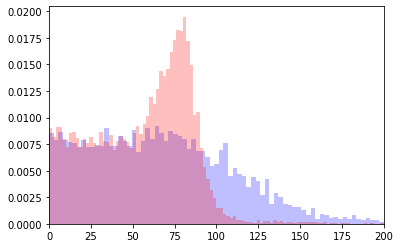

In [5]:
plt.hist(sgmt, 100, density=True, color = "blue", alpha=0.25)
plt.hist(bkmt, 100, density=True, color = "red" , alpha=0.25) #histtype='step'
plt.xlim([0, 200])
plt.show()

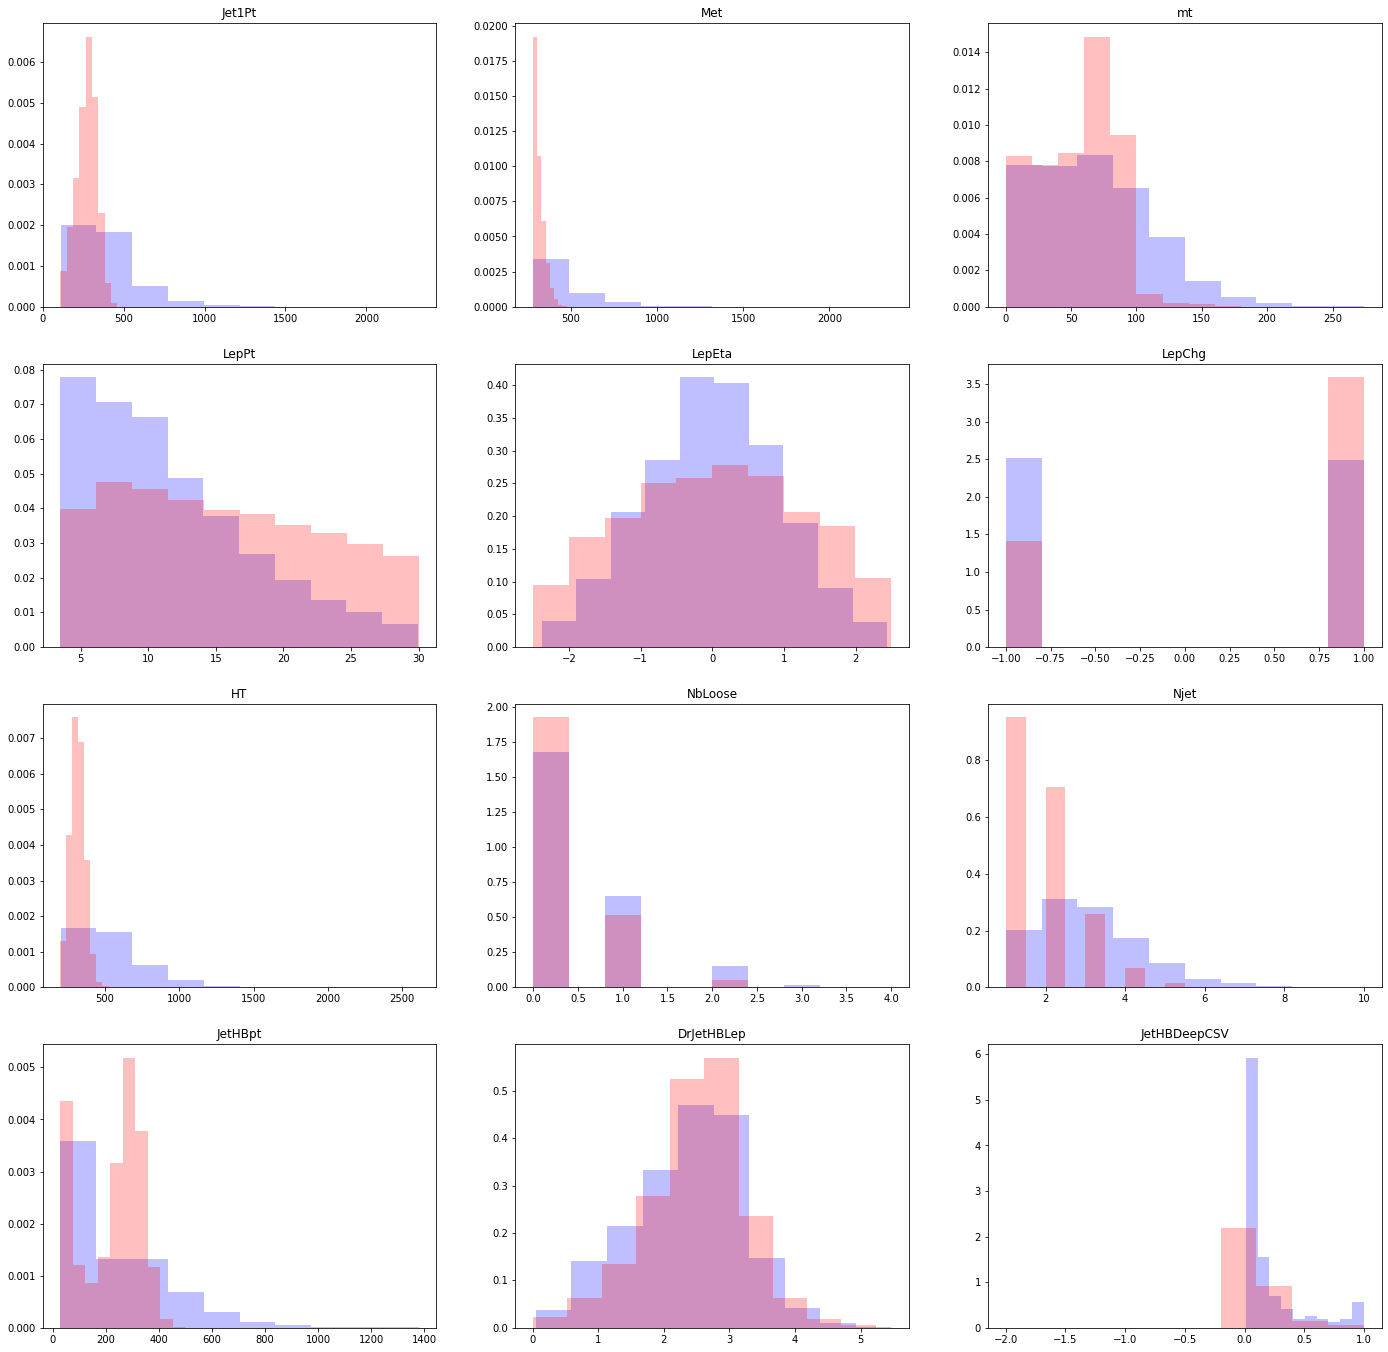

In [6]:
plt.rcParams['figure.figsize'] = [24, 24]
fig, axs = plt.subplots(4, 3)
#fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()
canvas = 0

for feature in myFeatures:
    axs[canvas].hist(sgDict[feature], density=True, color = "blue", alpha=0.25)
    axs[canvas].hist(bkDict[feature], density=True, color = "red", alpha=0.25)
    axs[canvas].set_title(feature)
    canvas+= 1
    #print(feature)
plt.show()

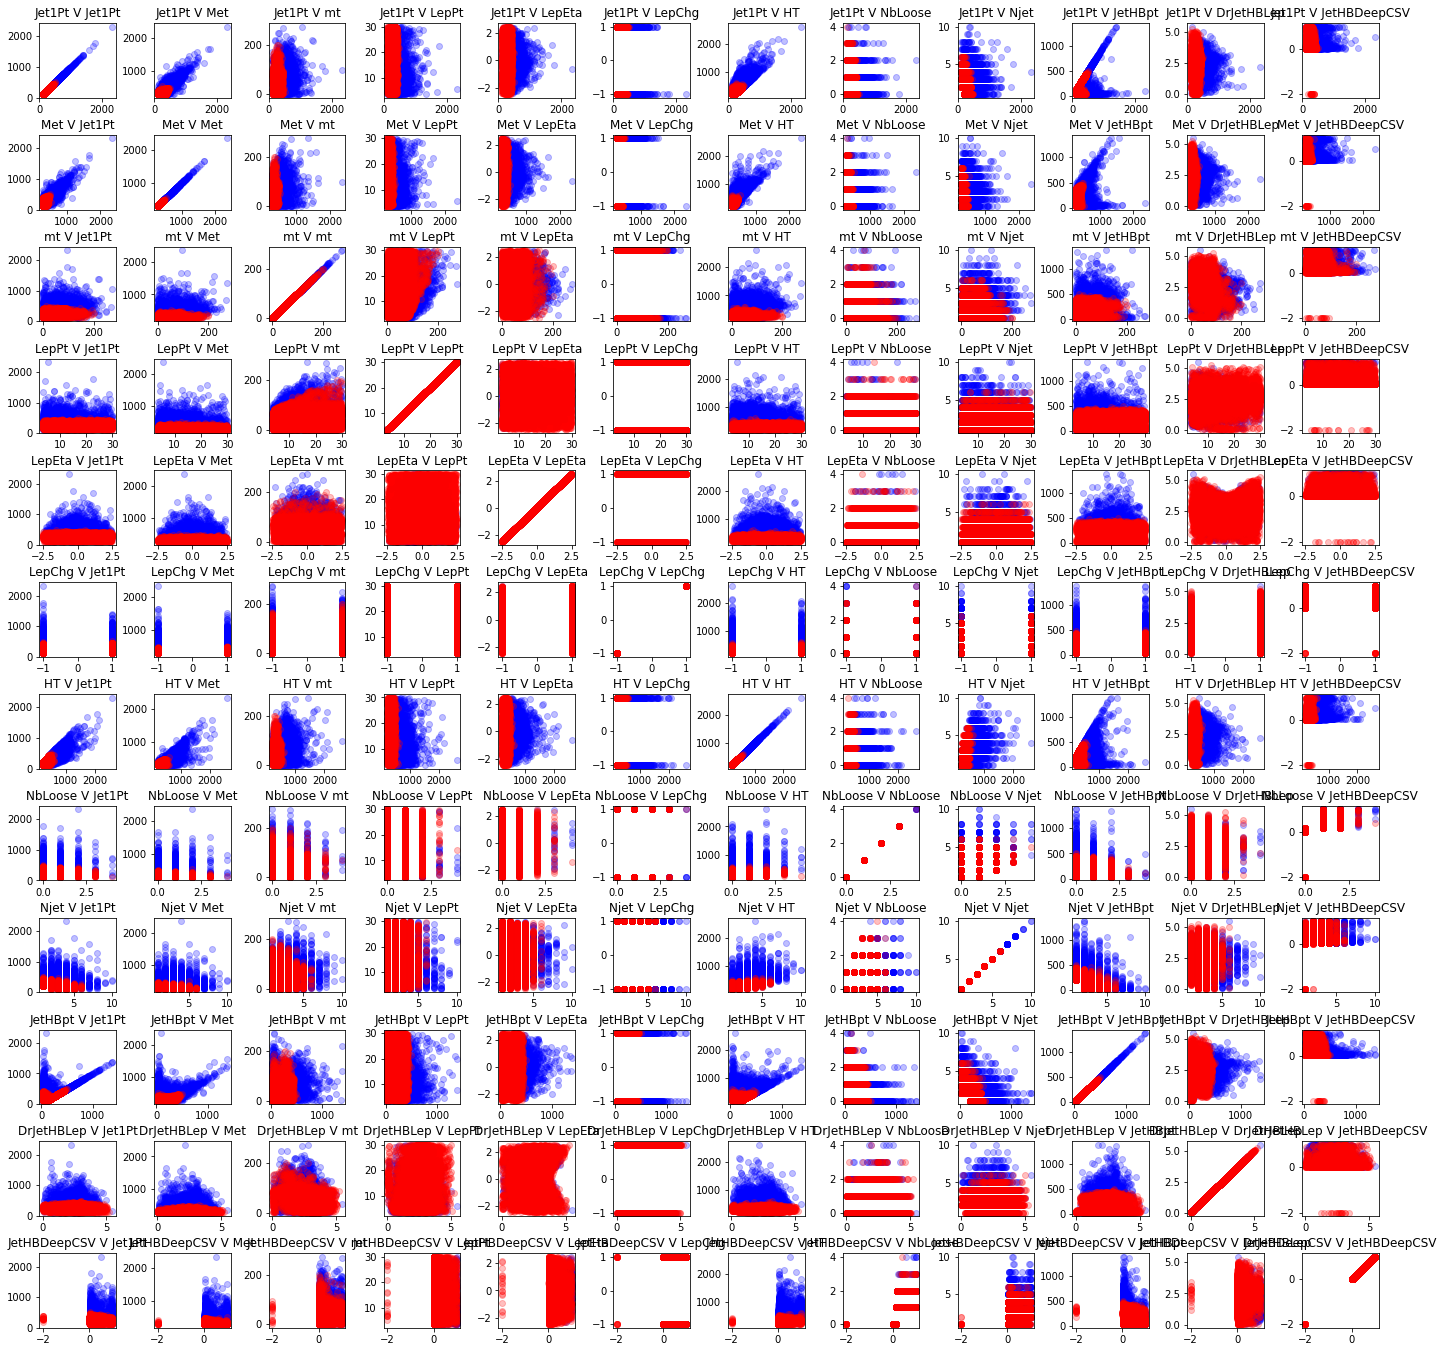

In [7]:
flist = ["LepPt", "Met", "Jet1Pt","mt"]
flist = myFeatures

plt.rcParams['figure.figsize'] = [24, 24]

fig, axs = plt.subplots(len(flist), len(flist))
#fig.subplots_adjust(hspace = 2, wspace=1)
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()
canvas = 0

for xFeature in flist:
    for yFeature in flist:
        axs[canvas].scatter(sgDict[xFeature], sgDict[yFeature], color = "blue", alpha=0.25)
        axs[canvas].scatter(bkDict[xFeature], bkDict[yFeature], color = "red", alpha=0.25)
        axs[canvas].set_title(xFeature+" V "+yFeature)
        canvas+= 1
plt.show()

In [8]:
# Add categoty
sgDict["XS"] = numpy.ones(sgJet1Pt.size)
sgDict["category"] = numpy.ones(sgJet1Pt.size)
bkDict["category"] = -numpy.ones(bkJet1Pt.size)

In [9]:
sgDF = pd.DataFrame(sgDict)
display(sgDF)

,XS,Nevt,Event,weight,Jet1Pt,Met,mt,LepPt,LepEta,LepChg,HT,NbLoose,Njet,JetHBpt,DrJetHBLep,JetHBDeepCSV,category
0,1.0,87155.0,374122677,1.660328e-06,358.50,495.763916,66.287491,9.832875,1.825684,-1.0,517.68750,0.0,3.0,358.50000,2.477360,0.096924,1.0
1,1.0,87155.0,374122819,1.081413e-06,382.75,294.244263,106.477509,19.571440,-1.339844,-1.0,382.75000,0.0,1.0,382.75000,4.031056,0.051941,1.0
2,1.0,87155.0,374122985,8.781268e-07,263.25,452.017548,54.583851,7.002269,0.790894,1.0,299.21875,0.0,2.0,263.25000,2.182332,0.096863,1.0
3,1.0,87155.0,374123459,1.402837e-06,458.25,619.445618,15.721840,18.753944,-0.114059,1.0,753.78125,1.0,6.0,57.15625,2.474060,0.388184,1.0
4,1.0,87155.0,15721703,2.418872e-06,514.00,612.521118,46.614670,10.367803,0.696045,-1.0,569.18750,0.0,2.0,514.00000,3.283460,0.039825,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,1.0,87155.0,420187995,1.260655e-06,288.75,292.965515,64.782486,8.685623,-1.313232,1.0,545.43750,0.0,3.0,188.37500,0.872331,0.070007,1.0
3471,1.0,87155.0,420187999,1.456874e-06,391.25,373.897644,88.149536,11.288665,1.731689,1.0,439.31250,1.0,2.0,391.25000,2.197504,0.286865,1.0
3472,1.0,87155.0,421150243,1.339093e-06,321.00,332.120636,104.815689,9.481251,0.224731,-1.0,321.00000,0.0,1.0,321.00000,1.503235,0.066345,1.0
3473,1.0,87155.0,421150477,1.574922e-06,320.00,347.891785,5.499272,5.202309,0.810547,1.0,320.00000,1.0,1.0,320.00000,2.904480,0.526855,1.0


In [10]:
bkDF = pd.DataFrame(bkDict)
display(bkDF)

,XS,Nevt,Event,weight,Jet1Pt,Met,mt,LepPt,LepEta,LepChg,HT,NbLoose,Njet,JetHBpt,DrJetHBLep,JetHBDeepCSV,category
0,407.899994,21250516.0,186969,2.959862e-05,257.500,314.997894,13.740556,9.744009,1.150879,-1.0,337.93750,1.0,2.0,257.50000,2.776972,0.220947,-1.0
1,407.899994,21250516.0,43941855,1.416709e-05,205.625,289.707642,28.436508,13.372465,-0.232910,1.0,387.90625,1.0,3.0,138.00000,2.917414,0.163696,-1.0
2,407.899994,21250516.0,90462929,2.595884e-05,144.500,412.164795,0.787054,5.453191,-0.400940,1.0,287.75000,1.0,2.0,144.50000,3.085957,0.284424,-1.0
3,407.899994,21250516.0,90467997,1.444754e-05,293.250,342.921143,92.996017,17.136381,0.855347,-1.0,330.09375,0.0,2.0,36.84375,2.587237,0.065918,-1.0
4,407.899994,21250516.0,90663941,1.565862e-06,189.375,290.784393,83.576836,6.006060,-0.061378,1.0,244.93750,0.0,2.0,55.56250,1.127103,0.043488,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14066,407.899994,21250516.0,152637049,1.754597e-05,295.500,313.942108,37.779633,10.321433,-0.027855,-1.0,295.50000,0.0,1.0,295.50000,2.600261,0.023087,-1.0
14067,407.899994,21250516.0,155856527,1.467571e-05,394.750,370.734650,48.072338,18.051493,-0.984985,1.0,394.75000,0.0,1.0,394.75000,2.614589,0.018326,-1.0
14068,407.899994,21250516.0,155859873,3.303919e-07,327.750,357.940735,11.259412,16.103882,-2.321289,-1.0,327.75000,0.0,1.0,327.75000,3.275612,0.049957,-1.0
14069,407.899994,21250516.0,151989749,1.536704e-05,323.750,296.777802,71.233147,10.747914,1.748535,1.0,356.31250,0.0,2.0,32.56250,0.923977,0.073486,-1.0


In [11]:
def dataForQDevice(n_samples, sampleDict, features):
    tensor = np.zeros([n_samples,len(features)])
    for ev in range(0,n_samples):
        event = np.zeros([1,len(features)])
        for feature in range(0,len(features)):
            event[0][feature] = sampleDict[features[feature]][ev]
            #event[0][feature] = sampleDict[features[feature]][ev]*sampleDict["XS"][ev]/n_samples
        #event=sampleDict["XS"][ev]
        tensor[ev] = event
    
    return tensor

In [12]:
#n_samples = 3000 #500
n_samples = 256
n_samples = 1024

features = ["LepPt", "Met", "Jet1Pt","mt"]
features = ["LepPt", "Met", "Jet1Pt","mt","HT","JetHBpt"]
weights  = ["XS","Nevt"]
features.extend(weights)
#features = myFeatures

#X0 = dataForQDevice(n_samples,sgDict,features)
#X1 = dataForQDevice(n_samples,bkDict,features)

#Y0 = np.array(sgDict["category"][:n_samples])
#Y1 = np.array(bkDict["category"][:n_samples])

#W0 = np.array(sgDict["XS"][:n_samples])/np.array(sgDict["Nevt"][:n_samples])
#W1 = np.array(bkDict["XS"][:n_samples])/np.array(bkDict["Nevt"][:n_samples])

sg_samples = sgJet1Pt.size
bk_samples = bkJet1Pt.size

X0 = dataForQDevice(sg_samples,sgDict,features)
X1 = dataForQDevice(bk_samples,bkDict,features)

Y0 = np.array(sgDict["category"][:sg_samples])
Y1 = np.array(bkDict["category"][:bk_samples])

W0 = np.array(sgDict["XS"][:sg_samples])/np.array(sgDict["Nevt"][:sg_samples])
W1 = np.array(bkDict["XS"][:bk_samples])/np.array(bkDict["Nevt"][:bk_samples])

X = np.concatenate([X0,X1], axis=0)
Y = np.concatenate([Y0,Y1], axis=0)
W = np.concatenate([W0,W1], axis=0)

# normalize data
X[:,:-2] = minmax_scale(X[:,:-2],feature_range=(0, numpy.pi))

# split data into train + validation and test
X_train_val , X_test , y_train_val , y_test=train_test_split(X , Y , test_size=0.2)

## Quantum

In [13]:
n_qubits = X.shape[1]-2

In [14]:
# quantum device
dev = qml.device('default.qubit', wires=n_qubits)
#dev = qml.device('default.mixed', wires=n_qubits)
#dev = qml.device('qiskit.aer', wires=n_qubits)

In [15]:
# quantum circuit
@qml.qnode(dev)
def circuit(weights, x=None):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    #qml.templates.BasicEntanglerLayers(w, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(wires=0))

# variational quantum classifier
def variational_classifier(theta_weights, theta_bias, x=None):
    weights=theta_weights
    bias=theta_bias
    return circuit(weights, x=x)+bias

In [16]:
# number of quantum layers
n_layers = 12
n_layers = 3
#n_layers = len(features)-2
#n_layers = (len(features)-2)*3

# draw random quantum node weights / initial weights
theta_weights = 0.01 * np.random.randn(n_layers, n_qubits, 3, requires_grad=True)
theta_bias = np.array(0.0, requires_grad=True)

circuit(theta_weights, X[2,:-2])
drawer = qml.draw(circuit)
print(qml.draw(circuit)(theta_weights, X[2,:-2]))

 0: ──╭AngleEmbedding(M0)──╭StronglyEntanglingLayers(M1)──┤ ⟨Z⟩ 
 1: ──├AngleEmbedding(M0)──├StronglyEntanglingLayers(M1)──┤     
 2: ──├AngleEmbedding(M0)──├StronglyEntanglingLayers(M1)──┤     
 3: ──├AngleEmbedding(M0)──├StronglyEntanglingLayers(M1)──┤     
 4: ──├AngleEmbedding(M0)──├StronglyEntanglingLayers(M1)──┤     
 5: ──╰AngleEmbedding(M0)──╰StronglyEntanglingLayers(M1)──┤     
M0 =
[0.41523562 0.26002991 0.21757067 0.62588882 0.12927393 0.54357262]
M1 =
[[[ 0.0058309   0.0098646   0.00458631]
  [-0.00711512 -0.00394704  0.00461485]
  [ 0.00665205  0.0006956   0.00139164]
  [ 0.02905614 -0.00836864 -0.01058973]
  [-0.00576585  0.00377049  0.02339952]
  [ 0.00756418  0.00989434 -0.00284554]]

 [[-0.01146876  0.01331425  0.00700211]
  [ 0.00406834 -0.00938433 -0.00255253]
  [ 0.00916348  0.01012003  0.02797696]
  [ 0.00692338 -0.00092069  0.00176692]
  [ 0.00372253 -0.01301596  0.01184119]
  [ 0.00182302  0.00103528  0.00502221]]

 [[ 0.01085832  0.00779365 -0.00674404]
  [ 0.00

<ipython-input-17-da9fda7069e8>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


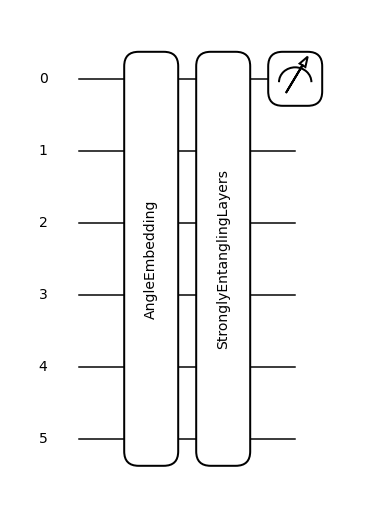

In [17]:
plt.rcParams['figure.figsize'] = [10,5]
qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(circuit)(theta_weights, X_test[2,:-2])
fig.show()

## Training

In [18]:
# split into train and validation
X_train , X_val , y_train , y_val = train_test_split(X_train_val, y_train_val, test_size =0.20)

# pca
#pca = decomposition.PCA(n_components=len(features)).fit(X_train)
#X_train = pca.transform(X_train)
#X_val = pca.transform(X_val)

data_train = list(zip(X_train, y_train))
data_val  = list(zip(X_val, y_val))

# select learning batch size
batch_size = 8
#batch_size = n_samples

# calculate number of batches
batches = len(X_train)// batch_size

# select number of epochs
n_epochs = 5

In [19]:
# build the optimizer object
#pennylane_opt = qml.GradientDescentOptimizer(0.2)
#pennylane_opt = qml.NesterovMomentumOptimizer(0.01)
#pennylane_opt = qml.NesterovMomentumOptimizer(0.3)
pennylane_opt = qml.AdagradOptimizer(0.3)
#pennylane_opt = qml.QNGOptimizer(0.1)

In [20]:
def loss(a, b):
    return (a - b)**2

def average_loss(theta_weights, theta_bias, data):
    c = 0
    sumWeights = 0
    for x, y in data:
        XS   = x[-2:-1]
        Nevt = x[-1]
        weight = float(XS/Nevt)
        prediction = variational_classifier(theta_weights, theta_bias, x[:-2])
        #prediction = np.sign(variational_classifier(theta_weights, theta_bias, x))
        c += (loss(prediction, y) * weight)
        sumWeights += weight
    return c/(len(data)*sumWeights)

In [21]:
def accuracy(theta_weights, theta_bias, data):
    y_pred = []
    y_true = []

    for x, y in data:
        prediction = np.sign(variational_classifier(theta_weights, theta_bias, x[:-2]))
        y_pred.append(prediction)
        y_true.append(y)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    return accuracy    

In [22]:
def pred(theta_weights, theta_bias, X):
    y_pred = []
    for x in X:
        prediction = variational_classifier(theta_weights, theta_bias, x[:-2])
        y_pred.append(prediction)
        
    return y_pred

In [23]:
loss_train  = []
loss_val    = []
accur_train = []
accur_val   = []

In [24]:
# train in ordered batches
X_batches = np.array_split(np.arange(len(X_train)), batches)
for it , batch_index in enumerate ( chain (*( n_epochs * [ X_batches ]))):
    y_train_batch = y_train[batch_index]
    X_train_batch = X_train[batch_index]
    data_train_batch = list(zip(X_train_batch, y_train_batch))

    ([theta_weights, theta_bias], avg_loss_batch) = pennylane_opt.step_and_cost(
    lambda theta_weights_, theta_bias_: average_loss(
        theta_weights_, theta_bias_, data_train_batch), theta_weights, theta_bias)

    #if it%n_epochs==0:
    if it==99999:
        avg_loss_train = average_loss(theta_weights, theta_bias, data_train)
        loss_train.append(avg_loss_train)
        avg_loss_val = average_loss(theta_weights, theta_bias, data_val)
        loss_val.append(avg_loss_val)
    
        acc_train = accuracy(theta_weights, theta_bias, data_train)
        acc_val = accuracy(theta_weights, theta_bias, data_val)
        acc_batch = accuracy(theta_weights, theta_bias, data_train_batch)

        accur_train.append(acc_train)
        accur_val.append(acc_val)
        print("Ep: {:2d} | Loss batch: {:0.7f} | Acc train: {:0.4f} val: {:0.4f}"
          "".format(it, avg_loss_batch, acc_train, acc_val))

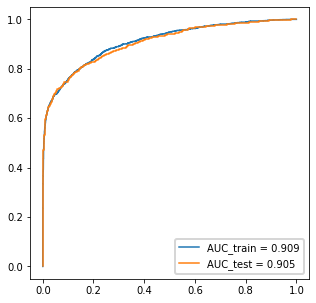

In [25]:
plt.rcParams['figure.figsize'] = [5,5]

y_pred_train = pred(theta_weights, theta_bias, X_train)
y_pred_test  = pred(theta_weights, theta_bias, X_test)

fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)

roc_auc_train = metrics.auc(fpr_train,tpr_train)
roc_auc = metrics.auc(fpr,tpr)

plt.plot(fpr_train,tpr_train, label='AUC_train = %0.3f' % (roc_auc_train))
plt.plot(fpr,tpr, label='AUC_test = %0.3f' % (roc_auc))
plt.legend(loc="lower right")

### _some testing..._

In [26]:
#print(qml.draw(circuit)(theta_weights, X[2]))

In [27]:
def pred3(theta_weights, theta_bias, X):
    y_pred = numpy.array([])
    for x in X:
        #prediction = np.sign(variational_classifier(theta_weights, theta_bias, x[:-2]))
        prediction = variational_classifier(theta_weights, theta_bias, x[:-2])
        y_pred = numpy.append(y_pred,prediction)
        
    return y_pred

In [28]:
data_test = list(zip(X_test, y_test))

acc_test  = accuracy(theta_weights, theta_bias, data_test)
acc_train = accuracy(theta_weights, theta_bias, data_train)
acc_val   = accuracy(theta_weights, theta_bias, data_val)

In [29]:
print("Acc train: {:0.1f} % | val: {:0.1f} % | test: {:0.1f} %"
      "".format(acc_train*100, acc_val*100, acc_test*100))

Acc train: 82.0 % | val: 81.5 % | test: 81.1 %


In [30]:
y_sig = pred3(theta_weights, theta_bias, X[:sg_samples])
y_bkg = pred3(theta_weights, theta_bias, X[sg_samples:])

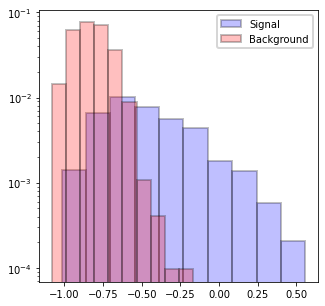

In [35]:
#plt.hist(y_sig, bins=25, color = "blue", weights=W0, alpha=0.25, label="Signal")
#plt.hist(y_bkg, bins=25, color = "red" , weights=W1, alpha=0.25, label="Background")
plt.hist(y_sig, color = "blue", weights=W0, alpha=0.25, label="Signal")
plt.hist(y_bkg, color = "red" , weights=W1, alpha=0.25, label="Background")
#plt.hist(y_sig , color = "blue", alpha=0.25, label="Signal")
#plt.hist(y_bkg, color = "red" , alpha=0.25, label="Background") #histtype='step'
plt.yscale('log')
#plt.xlim([-1, 1])
plt.legend(loc="best")
plt.show()

In [38]:
bins=np.arange(-1,0.1,1)
bins

tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], requires_grad=True)

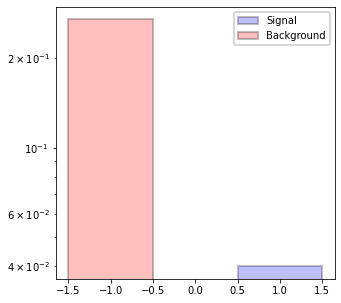

In [32]:
plt.hist(Y0, 1, weights=W0, color = "blue", alpha=0.25, label="Signal")
plt.hist(Y1, 1, weights=W1, color = "red" , alpha=0.25, label="Background") #histtype='step'
#plt.xlim([-1, 1])
plt.yscale('log')
plt.legend(loc="best")
plt.show()

### References

https://conference.ippp.dur.ac.uk/event/929/attachments/3968/4559/piotr_gawron_quantum_neural_networks.pdf

https://pennylane.ai/qml/demos/tutorial_variational_classifier.html

https://youtu.be/YtepXvx5zdI